In [1]:
pip install opencv-python numpy matplotlib


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Cristine\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


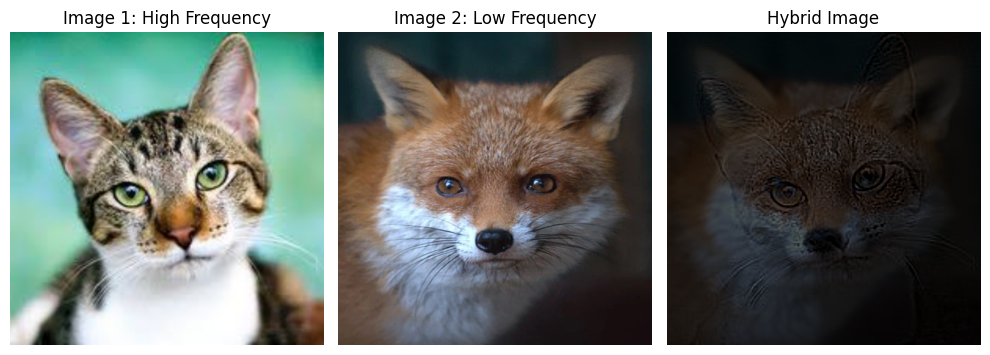

In [4]:
import cv2  # OpenCV library for computer vision tasks
import matplotlib.pyplot as plt  # For plotting and displaying images
import numpy as np  # For numerical operations on arrays

# Define file paths for input images
pic1 = r"C:\Users\Cristine\Documents\Python\IT322_BSIT3A_LAB2_AgadC_PacatangS\download-cushwfg.jpg"  # Path to first image (cat)
pic2 = r"C:\Users\Cristine\Documents\Python\IT322_BSIT3A_LAB2_AgadC_PacatangS\bobby_fox-image.webp"  # Path to second image (fox)

# Load both images using OpenCV's imread function
image1 = cv2.imread(pic1)  # Reads the first image from the specified path
image2 = cv2.imread(pic2)  # Reads the second image from the specified path

# Check if images are loaded successfully
if image1 is None:  # Checks if the first image was loaded successfully
    raise FileNotFoundError(f"Image 1 not found at {pic1}")  # Raises an error if the first image was not found
if image2 is None:  # Checks if the second image was loaded successfully
    raise FileNotFoundError(f"Image 2 not found at {pic2}")  # Raises an error if the second image was not found

# Resize both images to 512x512 pixels for consistency
image1 = cv2.resize(image1, (512, 512))  # Resizes the first image to 512x512 pixels
image2 = cv2.resize(image2, (512, 512))  # Resizes the second image to 512x512 pixels

# Convert from BGR (OpenCV default) to RGB color space
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)  # Converts the first image from BGR to RGB
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)  # Converts the second image from BGR to RGB

def correlation(image, kernel):
    """Perform cross-correlation between image and kernel."""
    h, w = image.shape[:2]  # Gets the height and width of the image
    kh, kw = kernel.shape  # Gets the height and width of the kernel
    pad_h, pad_w = kh // 2, kw // 2  # Calculates padding for height and width

    if len(image.shape) == 3:  # Color image
        output = np.zeros_like(image, dtype=np.float32)  # Creates an empty output array with the same shape as the input image
        for c in range(image.shape[2]):  # Iterates through the color channels
            padded = np.pad(image[:, :, c], ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')  # Pads the image with reflected values
            for i in range(h):  # Iterates through the rows of the image
                for j in range(w):  # Iterates through the columns of the image
                    output[i, j, c] = np.sum(padded[i:i + kh, j:j + kw] * kernel)  # Performs correlation operation
    else:  # Grayscale
        output = np.zeros((h, w), dtype=np.float32)  # Creates an empty output array for grayscale images
        padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')  # Pads the grayscale image
        for i in range(h):  # Iterates through the rows of the image
            for j in range(w):  # Iterates through the columns of the image
                output[i, j] = np.sum(padded[i:i + kh, j:j + kw] * kernel)  # Performs correlation operation

    return output  # Returns the correlated image

def convolution(image, kernel):
    """Perform convolution (correlation with flipped kernel)."""
    return correlation(image, np.flip(kernel))  # Calls the correlation function with a flipped kernel

def low(img, sigma, size):
    '''Apply low-pass filter to the image using a Gaussian kernel.'''
    kernel = np.zeros((size, size))  # Creates an empty kernel of the specified size
    center = int(size / 2)  # Calculates the center of the kernel
    for i in range(size):  # Iterates through the rows of the kernel
        for j in range(size):  # Iterates through the columns of the kernel
            kernel[i, j] = (1 / (2 * np.pi * sigma ** 2)) * np.exp(-((i - center) ** 2 + (j - center) ** 2) / (2 * sigma ** 2))  # Calculates the Gaussian kernel values
    kernel = kernel / np.sum(kernel)  # Normalizes the kernel
    return convolution(img, kernel)  # Performs convolution with the Gaussian kernel

def high(img, sigma, size):
    low_pass_img = low(img, sigma, size)  # Applies a low-pass filter to the image
    return img - low_pass_img  # Subtracts the low-pass image from the original image to get the high-pass image

def hybrid(img1, img2, sigma1, size1, high_low1, sigma2, size2, high_low2, mixin_ratio, scale_factor):
    img1 = img1.astype(np.float32) / 255.0  # Converts the first image to float32 and normalizes it
    img2 = img2.astype(np.float32) / 255.0  # Converts the second image to float32 and normalizes it

    img1 = low(img1, sigma1, size1) if high_low1 == 'low' else high(img1, sigma1, size1)  # Applies low-pass or high-pass filter based on the parameter
    img2 = low(img2, sigma2, size2) if high_low2 == 'low' else high(img2, sigma2, size2)  # Applies low-pass or high-pass filter based on the parameter

    img1 *= (1 - mixin_ratio)  # Scales the first image
    img2 *= mixin_ratio  # Scales the second image
    hybrid_img = (img1 + img2) * scale_factor  # Combines the two images and scales the result

    return np.clip(hybrid_img * 255, 0, 255).astype(np.uint8)  # Clips the pixel values and converts the image back to uint8

# Set parameters for hybrid image creation
sigma1 = 15  # Sigma for the first image's Gaussian filter
size1 = 7  # Size of the first image's Gaussian kernel
sigma2 = 10  # Sigma for the second image's Gaussian filter
size2 = 7  # Size of the second image's Gaussian kernel
high_low1 = 'high'  # Specifies whether to apply high-pass or low-pass filter to the first image
high_low2 = 'low'  # Specifies whether to apply high-pass or low-pass filter to the second image
mixin_ratio = 0.3  # Specifies the mixing ratio between the two images
scale_factor = 1.0  # Specifies the scaling factor for the hybrid image

# Create the hybrid image with specified parameters
hybrid_img = hybrid(image1, image2, sigma1, size1, high_low1, sigma2, size2, high_low2, mixin_ratio, scale_factor)  # Creates the hybrid image

# Display original images and result
plt.figure(figsize=(10, 6))  # Creates a figure for plotting
plt.subplot(1, 3, 1)  # Creates the first subplot
plt.imshow(image1)  # Displays the first image
plt.title("Image 1: High Frequency")  # Sets the title of the subplot
plt.axis('off')  # Turns off the axis

plt.subplot(1, 3, 2)  # Creates the second subplot
plt.imshow(image2)  # Displays the second image
plt.title("Image 2: Low Frequency")  # Sets the title of the subplot
plt.axis('off')  # Turns off the axis

plt.subplot(1, 3, 3)  # Creates the third subplot
plt.imshow(hybrid_img)  # Displays the hybrid image
plt.title("Hybrid Image")  # Sets the title of the subplot
plt.axis('off')  # Turns off the axis

plt.tight_layout()  # Adjusts subplot parameters to provide specified padding
plt.show()  # Displays the plot